In [1]:
# !pip install neurodsp
# !pip install emd
# !pip install umap-learn
# !pip install -U kaleido

In [13]:
# Load required libraries
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
from scipy.spatial import cKDTree
import pickle
import os

# Import custom functions
from scripts.functions import *
from scripts.structure_index import compute_structure_index, draw_graph

sns.set(style='white', context='notebook')

# Separate then Embed

In [75]:
# Set path to LFP data and sleep state files
path_to_data = './data/2018-07-26_14-20-46_Post-Trial5/'
data_file = 'Cleaned_PFC_100_CH52_0.continuous.mat'
states_file = '2018-07-26_14-20-46_Post-Trial5-states.mat'
pfc_data, sleep_scoring = load_mat_data(path_to_data, data_file, states_file)

In [76]:
def get_cycles_with_metrics(cycles, data, IA, IF, conditions=None):
  # C = copy.deepcopy(cycles)
  C.compute_cycle_timings()
    
  C.compute_cycle_metric('duration_samples', data, func=len)
  C.compute_cycle_metric('peak2trough', data, func=peak2trough)
  C.compute_cycle_metric('asc2desc', data, func=asc2desc)
  C.compute_cycle_metric('max_amp', IA, func=np.max)
  C.compute_cycle_metric('trough_values', data, func=np.min)
  C.compute_cycle_metric('peak_values', data, func=np.max)
  C.compute_cycle_metric('mean_if', IF, func=np.mean)
  C.compute_cycle_metric('max_if', IF, func=np.max)
  C.compute_cycle_metric('range_if', IF, func=compute_range)

  C.compute_cycle_metric('trough_position', data, func=np.argmin)
  C.compute_cycle_metric('peak_position', data, func=np.argmax)
  return C

In [95]:
pfc_data1, pfc_data2, pfc_data3, pfc_data4 = np.array_split(pfc_data, 4)
sleep_scoring1, sleep_scoring2, sleep_scoring3, sleep_scoring4 = np.array_split(sleep_scoring, 4)

In [102]:
fs = 1000
filtered_pfc_data1 = filter_signal(pfc_data1, fs, 'bandpass', (0.1, 4), n_cycles=3, filter_type='iir', butterworth_order=6, remove_edges=False)
IP1, IF1, IA1 = emd.spectra.frequency_transform(filtered_pfc_data1, fs, 'hilbert')
C = emd.cycles.Cycles(IP1)
cycles1 = get_cycles_with_metrics(C, filtered_pfc_data1, IA1, IF1)

filtered_pfc_data2 = filter_signal(pfc_data2, fs, 'bandpass', (0.1, 4), n_cycles=3, filter_type='iir', butterworth_order=6, remove_edges=False)
IP2, IF2, IA2 = emd.spectra.frequency_transform(filtered_pfc_data2, fs, 'hilbert')
C = emd.cycles.Cycles(IP2)
cycles2 = get_cycles_with_metrics(C, filtered_pfc_data2, IA2, IF2)

filtered_pfc_data3 = filter_signal(pfc_data3, fs, 'bandpass', (0.1, 4), n_cycles=3, filter_type='iir', butterworth_order=6, remove_edges=False)
IP3, IF3, IA3 = emd.spectra.frequency_transform(filtered_pfc_data3, fs, 'hilbert')
C = emd.cycles.Cycles(IP3)
cycles3 = get_cycles_with_metrics(C, filtered_pfc_data3, IA3, IF3)

filtered_pfc_data4 = filter_signal(pfc_data4, fs, 'bandpass', (0.1, 4), n_cycles=3, filter_type='iir', butterworth_order=6, remove_edges=False)
IP4, IF4, IA4 = emd.spectra.frequency_transform(filtered_pfc_data4, fs, 'hilbert')
C = emd.cycles.Cycles(IP4)
cycles4 = get_cycles_with_metrics(C, filtered_pfc_data4, IA4, IF4)

C:\Users\u525432\AppData\Roaming\Python\Python312\site-packages\neurodsp\filt\utils.py:90: RuntimeWarning:

divide by zero encountered in log10



 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'


In [ ]:
# Subset good cycles
metrics1 = cycles1.get_metric_dataframe()
metrics2 = cycles2.get_metric_dataframe()
metrics3 = cycles3.get_metric_dataframe()
metrics4 = cycles4.get_metric_dataframe()
all_metrics = pd.concat([metrics1, metrics2, metrics3, metrics4])

trough = 1
peak = 99
peak_thresh = np.percentile(all_metrics['peak_values'], peak)
trough_thresh = np.percentile(all_metrics['trough_values'], trough)

lo_freq_duration = 1000/0.5
hi_freq_duration = 1000/4

# Apply conditions to get good cycles
conditions_all_cycles = ['is_good==1',
                        f'peak_values<={peak_thresh}',
                        f'trough_values>={trough_thresh}',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}']

In [104]:
cycles1 = get_cycles_with_conditions(cycles1, conditions_all_cycles)
cycles2 = get_cycles_with_conditions(cycles2, conditions_all_cycles)
cycles3 = get_cycles_with_conditions(cycles3, conditions_all_cycles)
cycles4 = get_cycles_with_conditions(cycles4, conditions_all_cycles)

In [105]:
def get_cycle_state(sample_time, sleep_scoring):
    if sample_time//2500 >= len(sleep_scoring):
        return sleep_scoring[sample_time//2500 - 2]
    return sleep_scoring[sample_time//2500]

In [106]:
metrics1 = cycles1.get_metric_dataframe(subset=True)
metrics1['State'] = metrics1['stop_sample'].apply(get_cycle_state, sleep_scoring=sleep_scoring1)
metrics1['section'] = 1

metrics2 = cycles2.get_metric_dataframe(subset=True)
metrics2['State'] = metrics2['stop_sample'].apply(get_cycle_state, sleep_scoring=sleep_scoring2)
metrics2['section'] = 2

metrics3 = cycles3.get_metric_dataframe(subset=True)
metrics3['State'] = metrics3['stop_sample'].apply(get_cycle_state, sleep_scoring=sleep_scoring3)
metrics3['section'] = 3

metrics4 = cycles4.get_metric_dataframe(subset=True)
metrics4['State'] = metrics4['stop_sample'].apply(get_cycle_state, sleep_scoring=sleep_scoring4)
metrics4['section'] = 4

In [107]:
# Get phase-aligned cycle waveforms
waveforms1, _ = emd.cycles.phase_align(IP1, filtered_pfc_data1, cycles=cycles1.iterate(through='subset'), npoints=128)
waveforms1 = pd.DataFrame(waveforms1.T)

waveforms2, _ = emd.cycles.phase_align(IP2, filtered_pfc_data2, cycles=cycles2.iterate(through='subset'), npoints=128)
waveforms2 = pd.DataFrame(waveforms2.T)

waveforms3, _ = emd.cycles.phase_align(IP3, filtered_pfc_data3, cycles=cycles3.iterate(through='subset'), npoints=128)
waveforms3 = pd.DataFrame(waveforms3.T)

waveforms4, _ = emd.cycles.phase_align(IP4, filtered_pfc_data4, cycles=cycles4.iterate(through='subset'), npoints=128)
waveforms4 = pd.DataFrame(waveforms4.T)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


In [108]:
all_waveforms = pd.concat([waveforms1, waveforms2, waveforms3, waveforms4])

In [110]:
all_metrics = pd.concat([metrics1, metrics2, metrics3, metrics4])

In [111]:
all_data = pd.concat([all_metrics, all_waveforms], axis=1)

## Save Data

In [112]:
all_data.to_hdf('all_data.h5', key='PostTrial_5_sections', mode='a', format='table')

## Load Data

In [123]:
all_data = pd.read_hdf('all_data.h5', 'PostTrial_5_sections')

In [124]:
data1 = all_data[all_data['section'] == 1]
data2 = all_data[all_data['section'] == 2]
data3 = all_data[all_data['section'] == 3]
data4 = all_data[all_data['section'] == 4]

In [125]:
metrics1 = data1.iloc[:, :-128]
metrics2 = data2.iloc[:, :-128]
metrics3 = data3.iloc[:, :-128]
metrics4 = data4.iloc[:, :-128]
waveforms1 = np.array(data1.iloc[:, -128:])
waveforms2 = np.array(data2.iloc[:, -128:])
waveforms3 = np.array(data3.iloc[:, -128:])
waveforms4 = np.array(data4.iloc[:, -128:])

In [127]:
waveforms1.shape

(3455, 128)

## UMAP

In [132]:
ID1 = np.round(np.nanmean(abids(waveforms1, 50)))
ID2 = np.round(np.nanmean(abids(waveforms2, 50)))
ID3 = np.round(np.nanmean(abids(waveforms3, 50)))
ID4 = np.round(np.nanmean(abids(waveforms4, 50)))

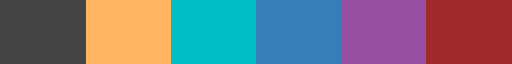

In [137]:
import matplotlib as mpl
cmap = mpl.colors.ListedColormap(["#444", "#FFB562", "#00bfc4", "#377eb8", "#984ea3", "#9e2a2b"])
cmap

In [214]:
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean', random_state=42)
embedding1 = umap_embedder.fit(waveforms1)
emb1 = embedding1.embedding_

umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean', random_state=42)
embedding2 = umap_embedder.fit(waveforms2)
emb2 = embedding2.embedding_

umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean', random_state=42)
embedding3 = umap_embedder.fit(waveforms3)
emb3 = embedding3.embedding_

umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean', random_state=42)
embedding4 = umap_embedder.fit(waveforms4)
emb4 = embedding4.embedding_

C:\Users\u525432\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

C:\Users\u525432\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

C:\Users\u525432\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

C:\Users\u525432\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [227]:
data = metrics1
from plotly.graph_objs.layout import Scene
from plotly.graph_objs.layout.scene import XAxis, YAxis, ZAxis

fig = px.scatter_3d(x=emb1[:,0], y=emb1[:,1], z=emb1[:,2],
              color=data['State'], color_discrete_sequence=["#FFB562", "#666", "#00bfc4", "#377eb8", "#984ea3", "#9e2a2b"])
fig.update_layout(coloraxis_colorbar_title_text = 'State',
                 autosize=False,
                 width=800,
                 height=600,
                 scene=Scene(xaxis=XAxis(title='UMAP-1'),
                            yaxis=YAxis(title='UMAP-2'),
                            zaxis=ZAxis(title='UMAP-3')))
fig.show()
# fig.write_html("./Rat6_ORN_3D_embedding.html")
# fig.write_image("Rat6_ORN_3D_embedding.png", engine="kaleido")

In [226]:
data1 = emb1
data2 = np.copy(emb2)
data2[:, 2] += 8
data3 = np.copy(emb3)
data3[:, 2] += 16
data4 = np.copy(emb4)
data4[:, 2] += 24
data = np.concatenate([data1, data2, data3, data4])
state_metric = np.concatenate([metrics1['State'], metrics2['State'], metrics3['State'], metrics4['State']])

from plotly.graph_objs.layout import Scene
from plotly.graph_objs.layout.scene import XAxis, YAxis, ZAxis

fig = px.scatter_3d(x=data[:,0], y=data[:,1], z=data[:,2],
              color=state_metric, color_discrete_sequence=["#FFB562" , "#00bfc4", "#377eb8", "#984ea3", "#9e2a2b"])#"#666",
fig.update_layout(coloraxis_colorbar_title_text = 'State',
                 autosize=False,
                 width=800,
                 height=800,
                 scene=Scene(xaxis=XAxis(title='UMAP-1'),
                            yaxis=YAxis(title='UMAP-2'),
                            zaxis=ZAxis(title='UMAP-3')))
fig.show()
# fig.write_html("./Rat6_ORN_3D_embedding.html")
# fig.write_image("Rat6_ORN_3D_embedding.png", engine="kaleido")

In [43]:
params = {
    'n_bins': 10,
    'n_neighbors': 15,
    'discrete_label': False,
    'num_shuffles': 10,
    'verbose': False,
}

In [44]:
SI_orn, binLabel_orn, overlapMat_orn, sSI_orn = compute_structure_index(emb, np.array(data['State']), **params)

C:\Users\u525432\Downloads\Delta_Detection\scripts\structure_index.py:420: UserWarning:

Along column 0, input 'label' has less unique values (4) than specified in 'n_bins' (10). Changing 'n_bins' to 4 and setting it to discrete.



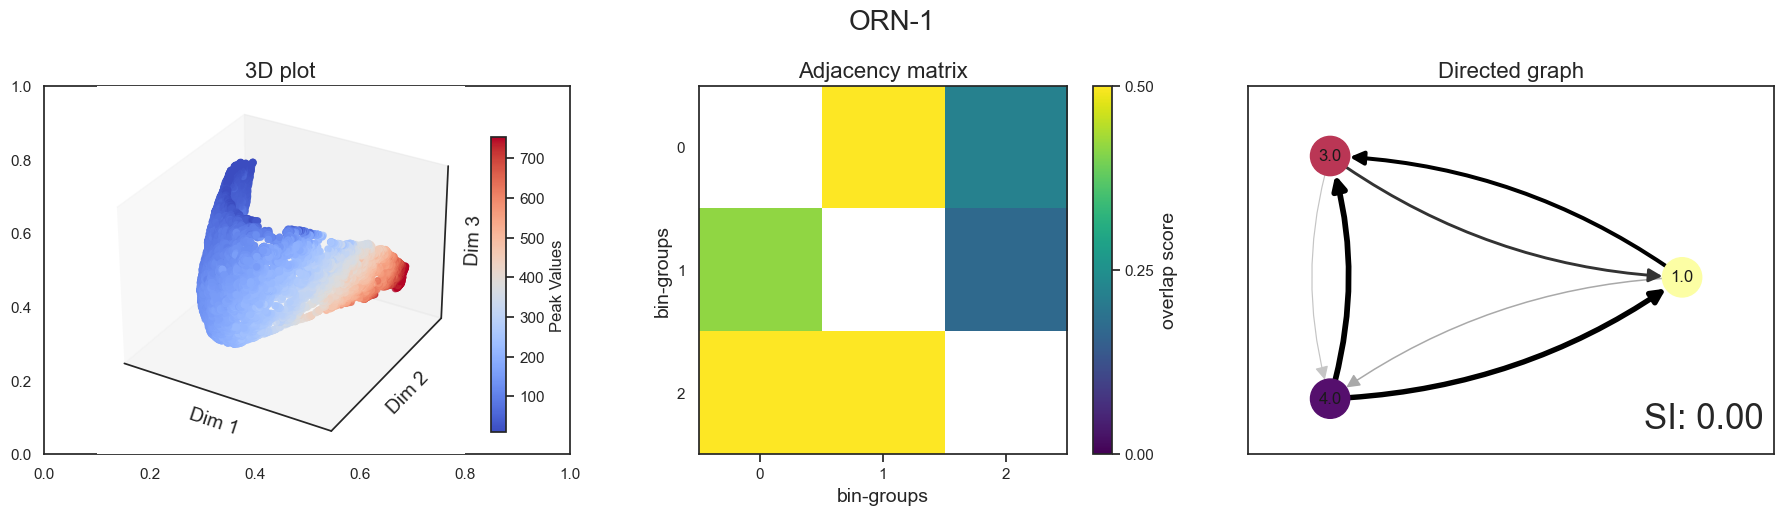

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

# plot 3D scatter
# also you can set vmin and vmax to your specific data
at = plt.subplot(1,3,1,projection = '3d')
b = at.scatter(*emb[:, :3].T, c = np.array(data['peak_values']), cmap = 'coolwarm',
               vmin= np.percentile(data['peak_values'],1),
               vmax = np.percentile(data['peak_values'],99))
cbar = fig.colorbar(b,ax=at,anchor=(0, 0.3), shrink=0.8)
cbar.set_label('Peak Values', rotation=90)
at.set_title(f'3D plot', size=16);
at.set_xlabel('Dim 1', labelpad=-8, size=14)
at.set_ylabel('Dim 2', labelpad=-8, size=14)
at.set_zlabel('Dim 3', labelpad=-8, size=14)
at.set_xticks([])
at.set_yticks([])
at.set_zticks([])

# plot adjacency matrix
b = ax[1].matshow(overlapMat_orn, vmin = 0, vmax = 0.5, cmap = plt.cm.viridis)
ax[1].xaxis.set_ticks_position('bottom')
cbar = fig.colorbar(b,ax=ax[1],anchor=(0, 0.2), shrink=1, ticks=[0,0.25,0.5])
cbar.set_label('overlap score', rotation=90, fontsize = 14)
ax[1].set_title('Adjacency matrix', size=16);
ax[1].set_xlabel('bin-groups', size=14)
ax[1].set_ylabel('bin-groups', size=14)

# plot weighted directed graph
draw_graph(overlapMat_orn, ax[2],node_cmap=plt.cm.inferno_r,edge_cmap=plt.cm.Greys,
                                  node_names = np.round(binLabel_orn[1][:,0,1],2));
ax[2].set_xlim(1.2*np.array(ax[2].get_xlim()));
ax[2].set_ylim(1.2*np.array(ax[2].get_ylim()));
ax[2].set_title('Directed graph', size=16);
ax[2].text(0.98, 0.05, f"SI: {SI_orn:.2f}", horizontalalignment='right',
     verticalalignment='bottom', transform=ax[2].transAxes,fontsize=25)
fig.suptitle('ORN-1', fontsize=20)
plt.tight_layout()

# Embed then separate

In [4]:
# Set path to LFP data and sleep state files
path_to_data = './data/2018-07-26_14-20-46_Post-Trial5/'
data_file = 'Cleaned_PFC_100_CH52_0.continuous.mat'
states_file = '2018-07-26_14-20-46_Post-Trial5-states.mat'
pfc_data, sleep_scoring = load_mat_data(path_to_data, data_file, states_file)

In [31]:
def get_cycles_with_metrics(cycles, data, IA, IF, conditions=None):
  # C = copy.deepcopy(cycles)
  C.compute_cycle_timings()
    
  C.compute_cycle_metric('duration_samples', data, func=len)
  C.compute_cycle_metric('peak2trough', data, func=peak2trough)
  C.compute_cycle_metric('asc2desc', data, func=asc2desc)
  C.compute_cycle_metric('max_amp', IA, func=np.max)
  C.compute_cycle_metric('trough_values', data, func=np.min)
  C.compute_cycle_metric('peak_values', data, func=np.max)
  C.compute_cycle_metric('mean_if', IF, func=np.mean)
  C.compute_cycle_metric('max_if', IF, func=np.max)
  C.compute_cycle_metric('range_if', IF, func=compute_range)

  C.compute_cycle_metric('trough_position', data, func=np.argmin)
  C.compute_cycle_metric('peak_position', data, func=np.argmax)
  return C

In [33]:
fs = 1000
filtered_pfc_data = filter_signal(pfc_data, fs, 'bandpass', (0.1, 4), n_cycles=3, filter_type='iir', butterworth_order=6, remove_edges=False)
IP, IF, IA = emd.spectra.frequency_transform(filtered_pfc_data, fs, 'hilbert')
C = emd.cycles.Cycles(IP)
cycles = get_cycles_with_metrics(C, filtered_pfc_data, IA, IF)

In [35]:
metrics = cycles.get_metric_dataframe()
trough = 1
peak = 99
peak_thresh = np.percentile(metrics['peak_values'], peak)
trough_thresh = np.percentile(metrics['trough_values'], trough)

lo_freq_duration = 1000/0.5
hi_freq_duration = 1000/4

# Apply conditions to get good cycles
conditions_all_cycles = ['is_good==1',
                        f'peak_values<={peak_thresh}',
                        f'trough_values>={trough_thresh}',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}']

In [47]:
cycles = get_cycles_with_conditions(cycles, conditions_all_cycles)

In [49]:
metrics

index  is_good  start_sample  stop_sample  duration  duration_samples  \
0          5        1          2943         3232       290               290   
1          6        1          3233         3615       383               383   
2          7        1          3616         3946       331               331   
3          8        1          3947         4370       424               424   
4         10        1          5038         5412       375               375   
...      ...      ...           ...          ...       ...               ...   
13822  23373        1      10795859     10796252       394               394   
13823  23374        1      10796253     10796689       437               437   
13824  23376        1      10796931     10797254       324               324   
13825  23380        1      10800758     10801067       310               310   
13826  23381        1      10801068     10801410       343               343   

       peak2trough  asc2desc     max_amp  trough_values  peak_values  \
0         0.532878  0.524266  132.565314     -96.031291   109.982000   
1         0.293340  0.628226  126.061705    -111.790422    66.809716   
2         0.512174  0.536978  208.811262    -125.208993    70.469777   
3         0.444414  0.500489  213.653077    -135.375458   167.900959   
4         0.468170  0.523661  124.870245     -91.978012    81.096119   
...            ...       ...         ...            ...          ...   
13822     0.504189  0.546278  243.629574    -134.504314   207.476258   
13823     0.640006  0.617607  192.488479    -124.741199   184.300654   
13824     0.633492  0.501354  220.992667     -62.092895   218.643506   
13825     0.356821  0.495003  172.738807    -161.285288    58.126183   
13826     0.603140  0.490973  171.617703     -96.261483   167.613836   

        mean_if    max_if  range_if  trough_position  peak_position  \
0      3.452444  5.193712  3.047513              220             82   
1      2.608318  6.464933  5.999820              198             55   
2      3.020027  8.489494  7.642845              256            103   
3      2.361656  3.774431  2.299168              302             90   
4      2.664625  3.544438  2.083669              269             91   
...         ...       ...       ...              ...            ...   
13822  2.539204  3.145714  1.686689              278             99   
13823  2.291958  4.033113  2.976634              351            184   
13824  3.082579  5.673894  3.315680              259             98   
13825  3.228118  5.770176  3.439699              213             56   
13826  2.917582  4.762388  2.386095              277            102   

       chain_ind  State  
0              0      1  
1              0      1  
2              0      1  
3              0      1  
4              1      1  
...          ...    ...  
13822       4914      1  
13823       4914      1  
13824       4915      1  
13825       4916      1  
13826       4916      1  

[13827 rows x 18 columns]

In [334]:
def get_cycle_state(sample_time, sleep_scoring):
    if sample_time//1000 >= len(sleep_scoring):
        return sleep_scoring[sample_time//1000 - 2]
    return sleep_scoring[sample_time//1000]

def get_section(start_sample):
    if start_sample/(1000*60) <= 45:
        return 1
    elif start_sample/(1000*60) <= 90:
        return 2
    elif start_sample/(1000*60) <= 120:
        return 3
    return 4

In [336]:
metrics = cycles.get_metric_dataframe(subset=True)
metrics['State'] = metrics['stop_sample'].apply(get_cycle_state, sleep_scoring=sleep_scoring)
metrics['cycle_time'] = (metrics['start_sample']+metrics['stop_sample'])/(2*1000)
metrics['section'] = metrics['start_sample'].apply(get_section)

In [55]:
waveforms, _ = emd.cycles.phase_align(IP, filtered_pfc_data, cycles=cycles.iterate(through='subset'), npoints=128)
waveforms = pd.DataFrame(waveforms.T)

 Checking phase_align inputs - trimming singleton from input 'ip'


In [350]:
all_data = pd.concat([metrics, waveforms], axis=1)

## Divide data in 4

In [354]:
all_data.to_hdf('all_data.h5', key='PostTrial_5', mode='a', format='table')

# Read Data

In [14]:
all_data = pd.read_hdf('all_data.h5', 'PostTrial_5')

In [15]:
metrics = all_data.iloc[:, :-128]
waveforms = np.array(all_data.iloc[:, -128:])

In [16]:
metrics

index  is_good  start_sample  stop_sample  duration  duration_samples  \
0          5        1          2943         3232       290               290   
1          6        1          3233         3615       383               383   
2          7        1          3616         3946       331               331   
3          8        1          3947         4370       424               424   
4         10        1          5038         5412       375               375   
...      ...      ...           ...          ...       ...               ...   
13822  23373        1      10795859     10796252       394               394   
13823  23374        1      10796253     10796689       437               437   
13824  23376        1      10796931     10797254       324               324   
13825  23380        1      10800758     10801067       310               310   
13826  23381        1      10801068     10801410       343               343   

       peak2trough  asc2desc     max_amp  trough_values  peak_values  \
0         0.532878  0.524266  132.565314     -96.031291   109.982000   
1         0.293340  0.628226  126.061705    -111.790422    66.809716   
2         0.512174  0.536978  208.811262    -125.208993    70.469777   
3         0.444414  0.500489  213.653077    -135.375458   167.900959   
4         0.468170  0.523661  124.870245     -91.978012    81.096119   
...            ...       ...         ...            ...          ...   
13822     0.504189  0.546278  243.629574    -134.504314   207.476258   
13823     0.640006  0.617607  192.488479    -124.741199   184.300654   
13824     0.633492  0.501354  220.992667     -62.092895   218.643506   
13825     0.356821  0.495003  172.738807    -161.285288    58.126183   
13826     0.603140  0.490973  171.617703     -96.261483   167.613836   

        mean_if    max_if  range_if  trough_position  peak_position  \
0      3.452444  5.193712  3.047513              220             82   
1      2.608318  6.464933  5.999820              198             55   
2      3.020027  8.489494  7.642845              256            103   
3      2.361656  3.774431  2.299168              302             90   
4      2.664625  3.544438  2.083669              269             91   
...         ...       ...       ...              ...            ...   
13822  2.539204  3.145714  1.686689              278             99   
13823  2.291958  4.033113  2.976634              351            184   
13824  3.082579  5.673894  3.315680              259             98   
13825  3.228118  5.770176  3.439699              213             56   
13826  2.917582  4.762388  2.386095              277            102   

       chain_ind  State  cycle_time  section  
0              0      1      3.0875        1  
1              0      1      3.4240        1  
2              0      1      3.7810        1  
3              0      1      4.1585        1  
4              1      1      5.2250        1  
...          ...    ...         ...      ...  
13822       4914      1  10796.0555        4  
13823       4914      1  10796.4710        4  
13824       4915      1  10797.0925        4  
13825       4916      1  10800.9125        4  
13826       4916      1  10801.2390        4  

[13827 rows x 20 columns]

In [17]:
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean', random_state=42)
embedding = umap_embedder.fit(waveforms)
emb = embedding.embedding_

C:\Users\TEMP\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



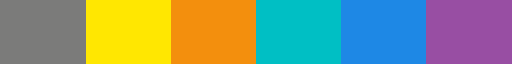

In [18]:
import matplotlib as mpl
cmap = mpl.colors.ListedColormap(["#7B7B7A", "#FFE701", "#F38F0D", "#00bfc4", "#1E88E5", "#984ea3"])
cmap

In [19]:
def get_section(start_sample, fs=2500):
    if start_sample/(fs*60) <= 45:
        return 1
    elif start_sample/(fs*60) <= 90:
        return 2
    elif start_sample/(fs*60) <= 135:
        return 3
    return 4

In [153]:
data = metrics
from plotly.graph_objs.layout import Scene
from plotly.graph_objs.layout.scene import XAxis, YAxis, ZAxis

fig = px.scatter_3d(x=emb[:,0], y=emb[:,1], z=emb[:,2],
              color=data['State'], color_discrete_map=state_color_map)

fig.update_layout(coloraxis_colorbar_title_text = 'State',
                 autosize=False,
                 width=800,
                 height=600,
                 scene=Scene(xaxis=XAxis(title='UMAP-1'),
                            yaxis=YAxis(title='UMAP-2'),
                            zaxis=ZAxis(title='UMAP-3')))
fig.show()
fig.write_html(f"./plots/PostTrial_5/PostTrial5_embedding.html")
# fig.write_image("Rat6_ORN_3D_embedding.png", engine="kaleido")

In [23]:
data = metrics

# Assign section based on start_sample and create z_offset using height_offsets
metrics['section'] = metrics['start_sample'].apply(get_section, args=(1000,))
height_offsets = {1: 0, 2: 10, 3: 20, 4: 30}
data['z_offset'] = emb[:, 2] + np.array(data['section'].map(height_offsets))

state_color_map = {
    0: "#7B7B7A",
    1: "#FFE701",
    2: "#F38F0D",
    3: "#00bfc4",
    4: "#1E88E5",
    5: "#984ea3",
}


# Create the 3D scatter plot
fig = px.scatter_3d(
    x=emb[:, 0], 
    y=emb[:, 1], 
    z=data['z_offset'],
    color=data['State'], 
    color_discrete_map=state_color_map
)

# Update layout
fig.update_layout(
    coloraxis_colorbar_title_text='State',
    autosize=False,
    width=800,
    height=800,
    scene=dict(
        xaxis=dict(title='UMAP-1'),
        yaxis=dict(title='UMAP-2'),
        zaxis=dict(title='UMAP-3')
    )
)

# Show and save the plot
fig.show()
fig.write_html("./plots/PostTrial_5/PostTrial5_split_embedding.html")
# fig.write_image("Rat6_ORN_3D_embedding.png", engine="kaleido")


### Structure Index

In [155]:
state = 5

In [156]:
metrics_section1 = metrics[(metrics['section'] == 1) & (metrics['State'] == state)]
metrics_section2 = metrics[(metrics['section'] == 2) & (metrics['State'] == state)]
metrics_section3 = metrics[(metrics['section'] == 3) & (metrics['State'] == state)]
metrics_section4 = metrics[(metrics['section'] == 4) & (metrics['State'] == state)]
emb_section1 = np.copy(emb[metrics_section1.index])
emb_section2 = np.copy(emb[metrics_section2.index])
emb_section3 = np.copy(emb[metrics_section3.index])
emb_section4 = np.copy(emb[metrics_section4.index])

In [168]:
params = {
    'n_bins': 6,
    'n_neighbors': 15,
    'discrete_label': False,
    'num_shuffles': 10,
    'verbose': False,
}

In [169]:
SI1, binLabel1, overlapMat1, sSI1 = compute_structure_index(emb_section1, np.array(metrics_section1['peak_values']), **params)
SI2, binLabel2, overlapMat2, sSI2 = compute_structure_index(emb_section2, np.array(metrics_section2['peak_values']), **params)
SI3, binLabel3, overlapMat3, sSI3 = compute_structure_index(emb_section3, np.array(metrics_section3['peak_values']), **params)
SI4, binLabel4, overlapMat4, sSI4 = compute_structure_index(emb_section4, np.array(metrics_section4['peak_values']), **params)

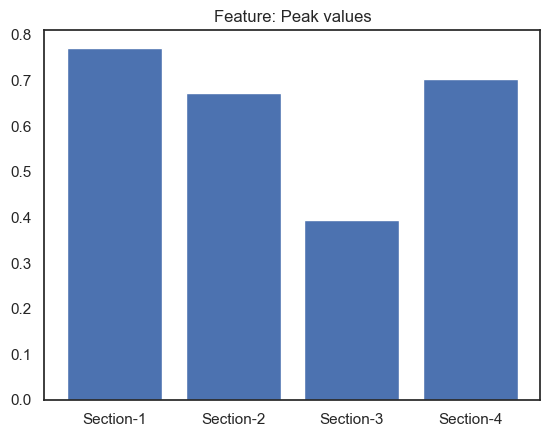

In [170]:
D = {'Section-1':SI1, 'Section-2': SI2, 'Section-3': SI3, 'Section-4':SI4}

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.title('Feature: Peak values');

In [171]:
def plot_SI(emb, feature, overlapMat, binLabel, SI):
    fig, ax = plt.subplots(1, 3, figsize=(18,5))
    
    # plot 3D scatter
    # also you can set vmin and vmax to your specific data
    at = plt.subplot(1,3,1,projection = '3d')
    b = at.scatter(*emb[:, :3].T, c = np.array(feature), cmap = 'coolwarm',
                   vmin= np.percentile(feature,1),
                   vmax = np.percentile(feature,99))
    cbar = fig.colorbar(b,ax=at,anchor=(0, 0.3), shrink=0.8)
    cbar.set_label('Peak Values', rotation=90)
    at.set_title(f'3D plot', size=16);
    at.set_xlabel('Dim 1', labelpad=-8, size=14)
    at.set_ylabel('Dim 2', labelpad=-8, size=14)
    at.set_zlabel('Dim 3', labelpad=-8, size=14)
    at.set_xticks([])
    at.set_yticks([])
    at.set_zticks([])
    
    # plot adjacency matrix
    b = ax[1].matshow(overlapMat, vmin = 0, vmax = 0.5, cmap = plt.cm.viridis)
    ax[1].xaxis.set_ticks_position('bottom')
    cbar = fig.colorbar(b,ax=ax[1],anchor=(0, 0.2), shrink=1, ticks=[0,0.25,0.5])
    cbar.set_label('overlap score', rotation=90, fontsize = 14)
    ax[1].set_title('Adjacency matrix', size=16);
    ax[1].set_xlabel('bin-groups', size=14)
    ax[1].set_ylabel('bin-groups', size=14)
    
    # plot weighted directed graph
    draw_graph(overlapMat, ax[2],node_cmap=plt.cm.inferno_r,edge_cmap=plt.cm.Greys,
                                      node_names = np.round(binLabel1[1][:,0,1],2));
    ax[2].set_xlim(1.2*np.array(ax[2].get_xlim()));
    ax[2].set_ylim(1.2*np.array(ax[2].get_ylim()));
    ax[2].set_title('Directed graph', size=16);
    ax[2].text(0.98, 0.05, f"SI: {SI:.2f}", horizontalalignment='right',
         verticalalignment='bottom', transform=ax[2].transAxes,fontsize=25)
    fig.suptitle('Section-1', fontsize=20)
    plt.tight_layout()
    # plt.savefig('orn_1_si.png')

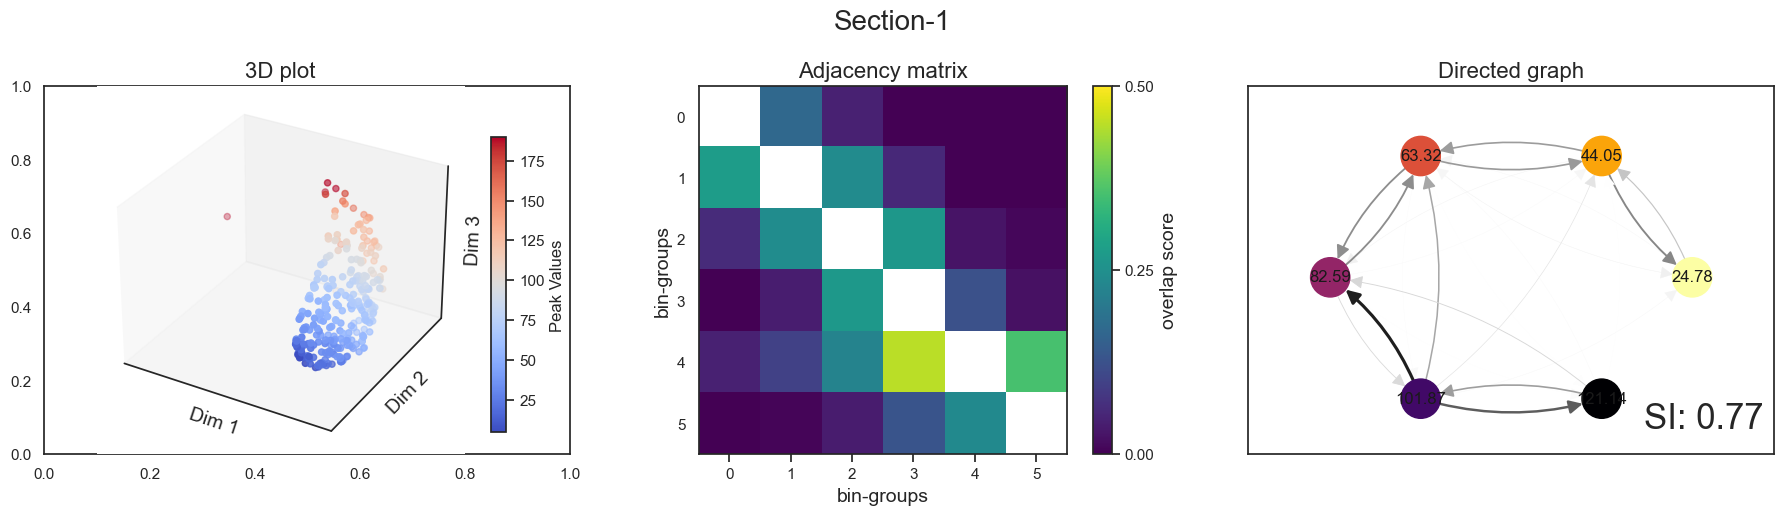

In [176]:
plot_SI(emb_section1, metrics_section1['peak_values'], overlapMat1, binLabel1, SI1)
plt.savefig("./plots/PostTrial_5/PostTrial5_section1_state5_SI.png")

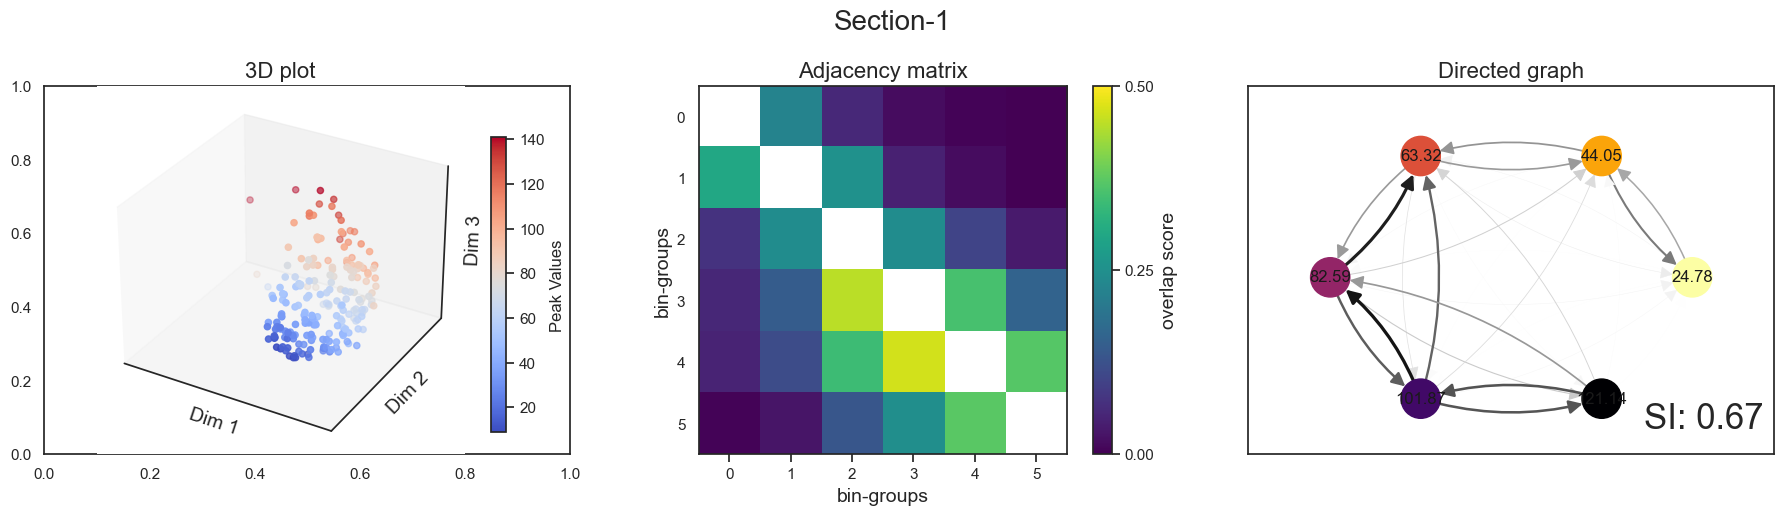

In [177]:
plot_SI(emb_section2, metrics_section2['peak_values'], overlapMat2, binLabel2, SI2)
plt.savefig("./plots/PostTrial_5/PostTrial5_section2_state5_SI.png")

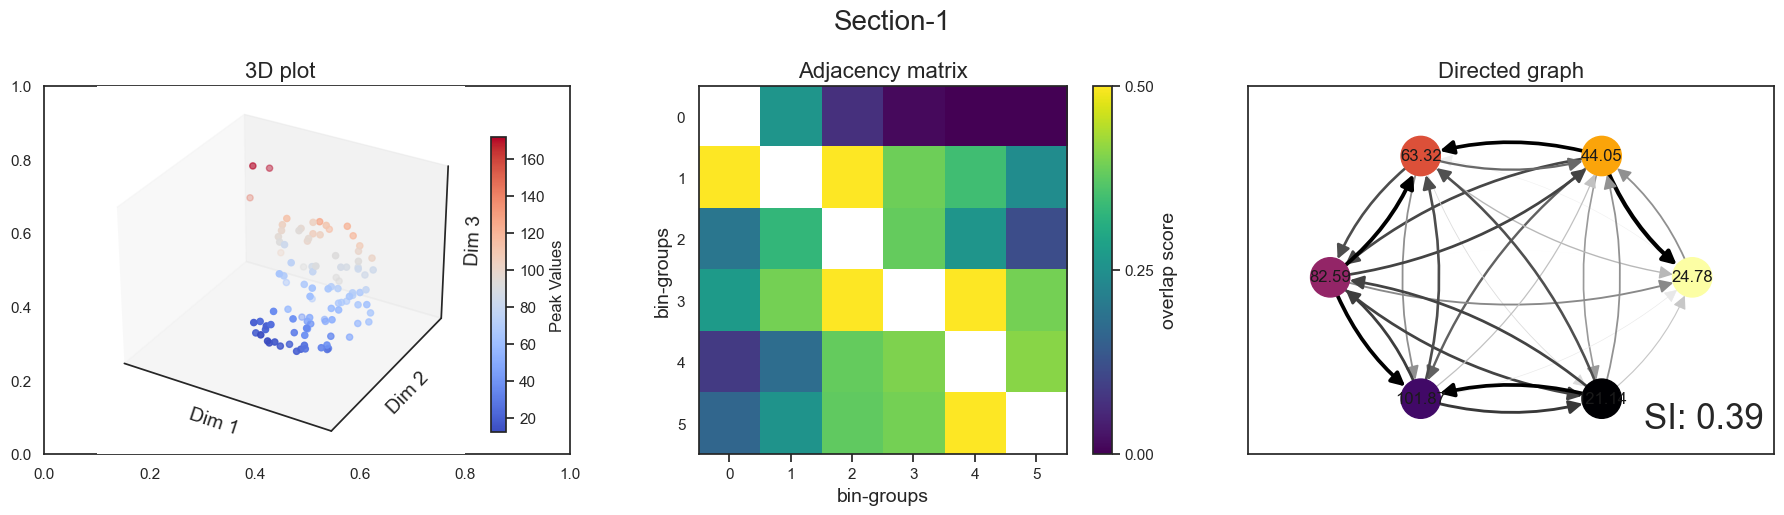

In [178]:
plot_SI(emb_section3, metrics_section3['peak_values'], overlapMat3, binLabel3, SI3)
plt.savefig("./plots/PostTrial_5/PostTrial5_section3_state5_SI.png")

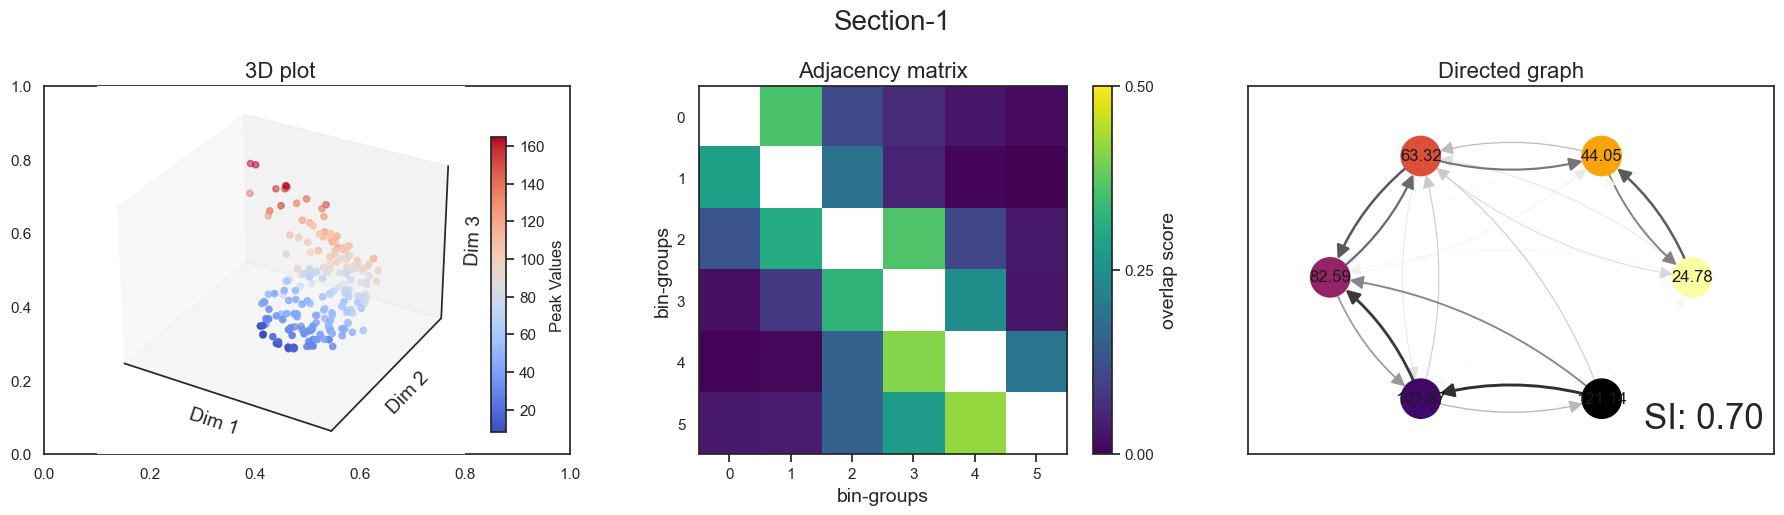

In [179]:
plot_SI(emb_section4, metrics_section4['peak_values'], overlapMat4, binLabel4, SI4)
plt.savefig("./plots/PostTrial_5/PostTrial5_section4_state5_SI.png")

### Centroids

In [138]:
state = 5

In [139]:
metrics_section1 = metrics[(metrics['section'] == 1) & (metrics['State'] == state)]
metrics_section2 = metrics[(metrics['section'] == 2) & (metrics['State'] == state)]
metrics_section3 = metrics[(metrics['section'] == 3) & (metrics['State'] == state)]
metrics_section4 = metrics[(metrics['section'] == 4) & (metrics['State'] == state)]
emb_section1 = np.copy(emb[metrics_section1.index])
emb_section2 = np.copy(emb[metrics_section2.index])
emb_section3 = np.copy(emb[metrics_section3.index])
emb_section4 = np.copy(emb[metrics_section4.index])

In [143]:
centroid_section1 = np.mean(emb_section1, axis=0)
centroid_section2 = np.mean(emb_section2, axis=0)
centroid_section3 = np.mean(emb_section3, axis=0)
centroid_section4 = np.mean(emb_section4, axis=0)

In [180]:
data = metrics

# Assign section based on start_sample and create z_offset using height_offsets
metrics['section'] = metrics['start_sample'].apply(get_section, args=(1000,))
height_offsets = {1: 0, 2: 10, 3: 20, 4: 30}
data['z_offset'] = emb[:, 2] + np.array(data['section'].map(height_offsets))

state_color_map = {
    0: "#7B7B7A",
    1: "#FFE701",
    2: "#F38F0D",
    3: "#00bfc4",
    4: "#1E88E5",
    5: "#984ea3",
}


# Create the 3D scatter plot
fig = px.scatter_3d(
    x=emb[:, 0], 
    y=emb[:, 1], 
    z=data['z_offset'],
    color=data['State'], 
    color_discrete_map=state_color_map
)

fig.add_scatter3d(
    x=[centroid_section1[0],centroid_section2[0],centroid_section3[0],centroid_section4[0]],
    y=[centroid_section1[1],centroid_section2[1],centroid_section3[1],centroid_section4[1]],
    z=[centroid_section1[2],centroid_section2[2]+height_offsets[2],centroid_section3[2]+height_offsets[3],centroid_section4[2]+height_offsets[4]],
    mode='markers',
    marker=dict(size=10, color='red', symbol='circle', opacity=1),
    name='Highlighted Point'  # Optional legend label
)

# Update layout
fig.update_layout(
    coloraxis_colorbar_title_text='State',
    autosize=False,
    width=800,
    height=800,
    scene=dict(
        xaxis=dict(title='UMAP-1'),
        yaxis=dict(title='UMAP-2'),
        zaxis=dict(title='UMAP-3')
    )
)

# Show and save the plot
fig.show()
fig.write_html("./plots/PostTrial_5/PostTrial5_state5_split_embedding.html")
# fig.write_image("Rat6_ORN_3D_embedding.png", engine="kaleido")
